# Dataset Exploration

The aim of this notebook is to explore all the data, labels and metadata available in the dataset to extract a valuable analysis to perform a better data collection and preprocessing.

## Imports

In [1]:
import os
import multiprocessing
from collections import Counter
import ast

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from lib.plot_utils import create_histogram
from lib.image_processing import load_numpy_data, get_stats
from lib.data_processing import get_labels_from_str

## Config

In [2]:
# Paths to the folders with the subjects data: "posi" = COVID patients, "neg" = No COVID patients
posi_path = "../../../datasets/BIMCV-COVID19-cIter_1_2/covid19_posi/"
neg_path = "../../../datasets/BIMCV-COVID19-cIter_1_2-Negative/covid19_neg/"

# Paths to the TSVs with all the images file pahts by subject and session
posi_partitions_path = os.path.join(posi_path, "derivatives/partitions.tsv")
neg_partitions_path = os.path.join(neg_path, "derivatives/partitions.tsv")

# Paths to the TSVs with the main labels (and medical report) for each session
posi_labels_path = os.path.join(posi_path, "derivatives/labels/labels_covid_posi.tsv")
neg_labels_path = os.path.join(neg_path, "derivatives/labels/Labels_covid_NEG_JAN21.tsv")

# Path to the TSV with the results of the COVID tests for each subject
#  Note: Only for the COVID patients ("posi")
covid_tests_path = os.path.join(posi_path, "derivatives/EHR/sil_reg_covid_posi.tsv")

# Path to the TSV with the common subjects between the positive and negative sets of data
common_sub_path = "../../../datasets/BIMCV-COVID19-cIter_1_2-Negative/listjoin_ok.tsv"

# Maximum number of cores to use during some exploration steps
max_cores = 6  # multiprocessing.cpu_count()

## Load TSVs of the dataset images

This TSVs contains for each unique pair of subject ID and session ID the corresponding path to the image of that session. The path is relative to the folder containing all the subjects folders. That folder will be "covid19_posi" or "covid_neg" depending on the type of patients.

#### 1. Positive patients

In [3]:
# Load dataframe with all the images of positive patients by session and subject
cols = ["subject", "session", "filepath"]  # The original columns must be fixed
posi_df = pd.read_csv(posi_partitions_path, sep="\t", header=0, names=cols)
posi_df.head()

,subject,session,filepath
0,sub-S03044,ses-E06138,./sub-S03044/ses-E06138/mod-rx/sub-S03044_ses-...
1,sub-S03044,ses-E06790,./sub-S03044/ses-E06790/mod-rx/sub-S03044_ses-...
2,sub-S03044,ses-E07712,./sub-S03044/ses-E07712/mod-rx/sub-S03044_ses-...
3,sub-S03045,ses-E06139,./sub-S03045/ses-E06139/mod-rx/sub-S03045_ses-...
4,sub-S03045,ses-E06910,./sub-S03045/ses-E06910/mod-rx/sub-S03045_ses-...


In [4]:
# Create auxiliary groupby views of the dataframe
posi_groupby_sub = posi_df.groupby(["subject"])
posi_groupby_sess = posi_df.groupby(["session"])

#### 2. Negative patients

In [5]:
# Load dataframe with all the images of positive patients by session and subject
cols = ["subject", "session", "filepath"]  # The original columns must be fixed
neg_df = pd.read_csv(neg_partitions_path, sep="\t", header=0, names=cols)
neg_df.head()

,subject,session,filepath
0,sub-S04523,ses-E08987,./sub-S04523/ses-E08987/sub-S04523_ses-E08987_...
1,sub-S04523,ses-E08987,./sub-S04523/ses-E08987/sub-S04523_ses-E08987_...
2,sub-S04523,ses-E13449,./sub-S04523/ses-E13449/sub-S04523_ses-E13449_...
3,sub-S04523,ses-E53140,./sub-S04523/ses-E53140/sub-S04523_ses-E53140_...
4,sub-S04523,ses-E53140,./sub-S04523/ses-E53140/sub-S04523_ses-E53140_...


In [6]:
# Create auxiliary groupby views of the dataframe
neg_groupby_sub = neg_df.groupby(["subject"])
neg_groupby_sess = neg_df.groupby(["session"])

## Load the list of common subjects

There are some patients that exist in the posi and neg sets but with different subject ID

In [7]:
common_df = pd.read_csv(common_sub_path, sep="\t")
common_df.head()

,label,covid19_neg,covid19_posi
0,1469,sub-S05216,sub-S08599
1,1470,sub-S04523,sub-S08600
2,1472,sub-S04525,sub-S08601
3,1473,sub-S04526,sub-S08602
4,1474,sub-S04527,sub-S08604


In [8]:
print(f"Number of common subjects between posi and neg sets: {len(common_df)}")

Number of common subjects between posi and neg sets: 810


## Dataset counts

#### 1. Positive patients

In [9]:
n_posi_subjects = posi_df['subject'].nunique()
n_posi_sessions = posi_df['session'].nunique()
n_posi_images = len(posi_df['filepath'])
print("In positive subjects tsv:")
print(f"Number of subjects: {n_posi_subjects}")
print(f"Number of sessions: {n_posi_sessions}")
print(f"Number of images: {n_posi_images}")

In positive subjects tsv:
Number of subjects: 4854
Number of sessions: 13368
Number of images: 23527


#### 2. Negative patients

In [10]:
n_neg_subjects = neg_df['subject'].nunique()
n_neg_sessions = neg_df['session'].nunique()
n_neg_images = len(neg_df['filepath'])
print("In negative subjects tsv:")
print(f"Number of subjects: {n_neg_subjects}")
print(f"Number of sessions: {n_neg_sessions}")
print(f"Number of images: {n_neg_images}")

In negative subjects tsv:
Number of subjects: 5201
Number of sessions: 7565
Number of images: 18573


### Check if the sessions ids are unique

#### 1. Positive patients

In [11]:
n_posi_sub_sess_pairs = posi_df.groupby(["subject", "session"]).ngroups
print("In positive subjects tsv:")
print(f" Total sessions: {n_posi_sessions}")
print(f" Total unique pairs of subject & session: {n_posi_sub_sess_pairs}")
print(f" Are sessions IDs unique? {n_posi_sessions == n_posi_sub_sess_pairs}")

In positive subjects tsv:
 Total sessions: 13368
 Total unique pairs of subject & session: 13368
 Are sessions IDs unique? True


#### 2. Negative patients

In [12]:
n_neg_sub_sess_pairs = neg_df.groupby(["subject", "session"]).ngroups
print("In negative subjects tsv:")
print(f" Total sessions: {n_neg_sessions}")
print(f" Total unique pairs of subject & session: {n_neg_sub_sess_pairs}")
print(f" Are sessions IDs unique? {n_neg_sessions == n_neg_sub_sess_pairs}")

In negative subjects tsv:
 Total sessions: 7565
 Total unique pairs of subject & session: 7565
 Are sessions IDs unique? True


### Check if there are subject ids that are repeated in posi and neg sets

In [13]:
n_repeated_sub = len(set(posi_df["subject"].unique()).intersection(set(neg_df["subject"].unique())))
print(f"Number of subject ids repeated between posi and neg sets: {n_repeated_sub}")

Number of subject ids repeated between posi and neg sets: 0


### Sessions by subject

#### 1. Positive patients

Count of sessions by subject:
 - mean: 2.75
 - median: 2.0
 - max: 38
 - min: 1


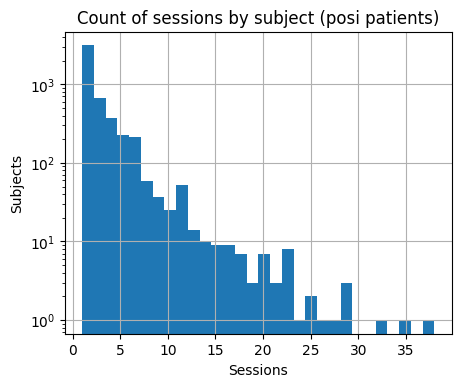

<Figure size 432x288 with 0 Axes>

In [14]:
# Get counts of sessions by subject
posi_sess_count_by_sub = posi_groupby_sub["session"].agg("nunique").values
print("Count of sessions by subject:")
print(f" - mean: {posi_sess_count_by_sub.mean():.2f}")
print(f" - median: {np.median(posi_sess_count_by_sub)}")
print(f" - max: {posi_sess_count_by_sub.max()}")
print(f" - min: {posi_sess_count_by_sub.min()}")
create_histogram(data=posi_sess_count_by_sub,
                 title="Count of sessions by subject (posi patients)",
                 ylabel="Subjects",
                 xlabel="Sessions")

#### 2. Negative patients

Count of sessions by subject:
 - mean: 1.45
 - median: 1.0
 - max: 22
 - min: 1


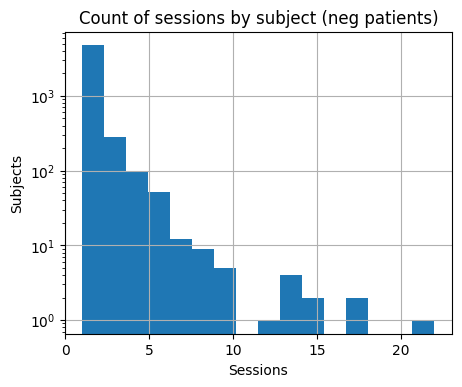

<Figure size 432x288 with 0 Axes>

In [15]:
# Get counts of sessions by subject
neg_sess_count_by_sub = neg_groupby_sub["session"].agg("nunique").values
print("Count of sessions by subject:")
print(f" - mean: {neg_sess_count_by_sub.mean():.2f}")
print(f" - median: {np.median(neg_sess_count_by_sub)}")
print(f" - max: {neg_sess_count_by_sub.max()}")
print(f" - min: {neg_sess_count_by_sub.min()}")
create_histogram(data=neg_sess_count_by_sub,
                 title="Count of sessions by subject (neg patients)",
                 ylabel="Subjects",
                 xlabel="Sessions")

#### 3. Positive + Negative patients

Count of sessions by subject:
 - mean: 2.08
 - median: 1.0
 - max: 38
 - min: 1


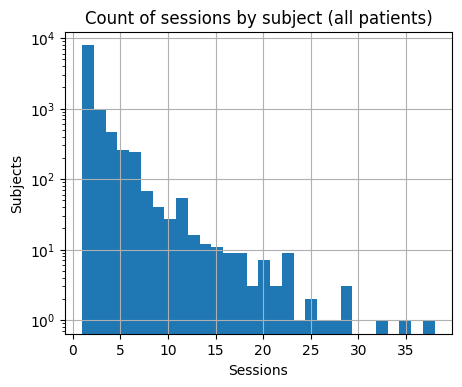

<Figure size 432x288 with 0 Axes>

In [16]:
# Get counts of sessions by subject
all_sess_count_by_sub = np.concatenate((posi_sess_count_by_sub, neg_sess_count_by_sub))
print("Count of sessions by subject:")
print(f" - mean: {all_sess_count_by_sub.mean():.2f}")
print(f" - median: {np.median(all_sess_count_by_sub)}")
print(f" - max: {all_sess_count_by_sub.max()}")
print(f" - min: {all_sess_count_by_sub.min()}")
create_histogram(data=all_sess_count_by_sub,
                 title="Count of sessions by subject (all patients)",
                 ylabel="Subjects",
                 xlabel="Sessions")

### Images by subject

#### 1. Positive patients

Count of images by subject:
 - mean: 4.85
 - median: 3.0
 - max: 139
 - min: 1


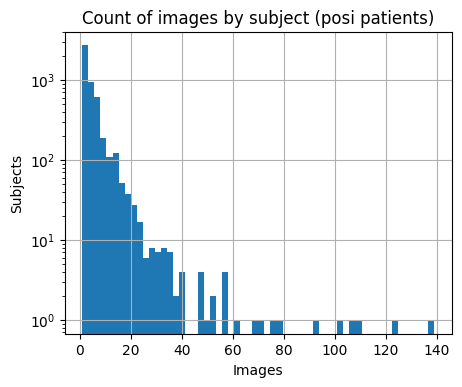

<Figure size 432x288 with 0 Axes>

In [17]:
# Get counts of images by subject
posi_imgs_count_by_sub = posi_groupby_sub["filepath"].agg("count").values
print("Count of images by subject:")
print(f" - mean: {posi_imgs_count_by_sub.mean():.2f}")
print(f" - median: {np.median(posi_imgs_count_by_sub)}")
print(f" - max: {posi_imgs_count_by_sub.max()}")
print(f" - min: {posi_imgs_count_by_sub.min()}")
create_histogram(data=posi_imgs_count_by_sub,
                 title="Count of images by subject (posi patients)",
                 ylabel="Subjects",
                 xlabel="Images")

#### 2. Negative patients

Count of images by subject:
 - mean: 3.57
 - median: 2.0
 - max: 34
 - min: 1


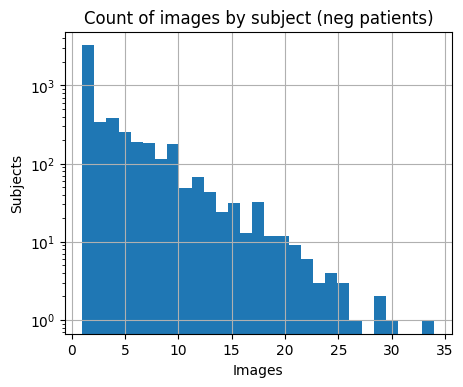

<Figure size 432x288 with 0 Axes>

In [18]:
# Get counts of images by subject
neg_imgs_count_by_sub = neg_groupby_sub["filepath"].agg("count").values
print("Count of images by subject:")
print(f" - mean: {neg_imgs_count_by_sub.mean():.2f}")
print(f" - median: {np.median(neg_imgs_count_by_sub)}")
print(f" - max: {neg_imgs_count_by_sub.max()}")
print(f" - min: {neg_imgs_count_by_sub.min()}")
create_histogram(data=neg_imgs_count_by_sub,
                 title="Count of images by subject (neg patients)",
                 ylabel="Subjects",
                 xlabel="Images")

#### 3. Positive + Negative patients

Count of images by subject:
 - mean: 4.19
 - median: 2.0
 - max: 139
 - min: 1


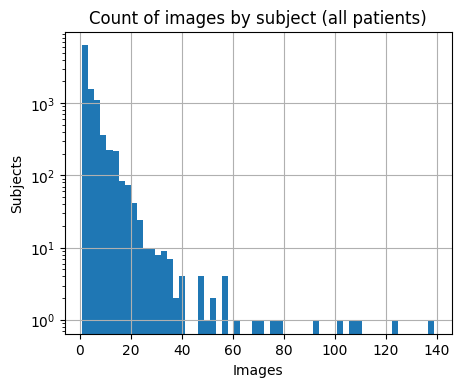

<Figure size 432x288 with 0 Axes>

In [19]:
# Get counts of images by subject
all_imgs_count_by_sub = np.concatenate((posi_imgs_count_by_sub, neg_imgs_count_by_sub))
print("Count of images by subject:")
print(f" - mean: {all_imgs_count_by_sub.mean():.2f}")
print(f" - median: {np.median(all_imgs_count_by_sub)}")
print(f" - max: {all_imgs_count_by_sub.max()}")
print(f" - min: {all_imgs_count_by_sub.min()}")
create_histogram(data=all_imgs_count_by_sub,
                 title="Count of images by subject (all patients)",
                 ylabel="Subjects",
                 xlabel="Images")

### Images by session

#### 1. Positive patients

Count of images by session:
 - mean: 1.76
 - median: 1.0
 - max: 135
 - min: 1


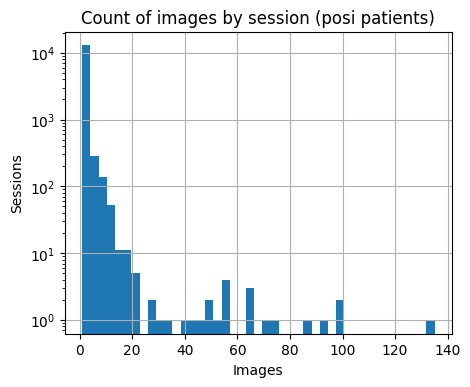

<Figure size 432x288 with 0 Axes>

In [20]:
# Get counts of images by session
posi_imgs_count_by_sess = posi_groupby_sess["filepath"].agg("count").values
print("Count of images by session:")
print(f" - mean: {posi_imgs_count_by_sess.mean():.2f}")
print(f" - median: {np.median(posi_imgs_count_by_sess)}")
print(f" - max: {posi_imgs_count_by_sess.max()}")
print(f" - min: {posi_imgs_count_by_sess.min()}")
create_histogram(data=posi_imgs_count_by_sess,
                 title="Count of images by session (posi patients)",
                 ylabel="Sessions",
                 xlabel="Images")

#### 2. Negative patients

Count of images by session:
 - mean: 2.46
 - median: 2.0
 - max: 22
 - min: 1


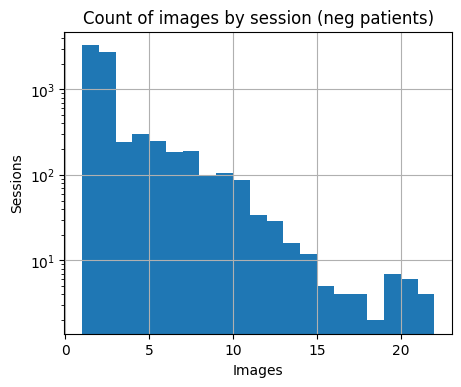

<Figure size 432x288 with 0 Axes>

In [21]:
# Get counts of images by session
neg_imgs_count_by_sess = neg_groupby_sess["filepath"].agg("count").values
print("Count of images by session:")
print(f" - mean: {neg_imgs_count_by_sess.mean():.2f}")
print(f" - median: {np.median(neg_imgs_count_by_sess)}")
print(f" - max: {neg_imgs_count_by_sess.max()}")
print(f" - min: {neg_imgs_count_by_sess.min()}")
create_histogram(data=neg_imgs_count_by_sess,
                 title="Count of images by session (neg patients)",
                 ylabel="Sessions",
                 xlabel="Images")

#### 3. Positive + Negative patients

Count of images by session:
 - mean: 2.01
 - median: 1.0
 - max: 135
 - min: 1


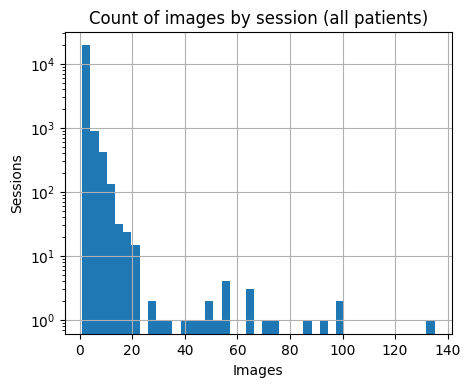

<Figure size 432x288 with 0 Axes>

In [22]:
# Get counts of images by session
all_imgs_count_by_sess = np.concatenate((posi_imgs_count_by_sess, neg_imgs_count_by_sess))
print("Count of images by session:")
print(f" - mean: {all_imgs_count_by_sess.mean():.2f}")
print(f" - median: {np.median(all_imgs_count_by_sess)}")
print(f" - max: {all_imgs_count_by_sess.max()}")
print(f" - min: {all_imgs_count_by_sess.min()}")
create_histogram(data=all_imgs_count_by_sess,
                 title="Count of images by session (all patients)",
                 ylabel="Sessions",
                 xlabel="Images")

## Images analysis

### Count of images views

Here we count how many images are anterior-posterior (AP) or posterior-anterior (PA). This views are the ones we are interested in.

In [23]:
# Get all the paths to the images
posi_img_files = posi_df["filepath"].values
neg_img_files = neg_df["filepath"].values

# Filter positive patients
posi_ap_pa_imgs = []
posi_not_ap_pa_imgs = []
for f_name in posi_img_files:
    if "vp-ap" in f_name or "vp-pa" in f_name:
        posi_ap_pa_imgs.append(f_name)
    else:
        posi_not_ap_pa_imgs.append(f_name)
        
# Filter negative patients
neg_ap_pa_imgs = []
neg_not_ap_pa_imgs = []
for f_name in neg_img_files:
    if "vp-ap" in f_name or "vp-pa" in f_name:
        neg_ap_pa_imgs.append(f_name)
    else:
        neg_not_ap_pa_imgs.append(f_name)
        

print("AP and PA images count:")
print(f" - posi  = {len(posi_ap_pa_imgs):>5}")
print(f" - neg   = {len(neg_ap_pa_imgs):>5}")
print(f" - total = {len(posi_ap_pa_imgs) + len(neg_ap_pa_imgs):>5}")

print("\nOther views count:")
print(f" - posi  = {len(posi_not_ap_pa_imgs):>5}")
print(f" - neg   = {len(neg_not_ap_pa_imgs):>5}")
print(f" - total = {len(posi_not_ap_pa_imgs) + len(neg_not_ap_pa_imgs):>5}")

AP and PA images count:
 - posi  = 13141
 - neg   =  6661
 - total = 19802

Other views count:
 - posi  = 10386
 - neg   = 11912
 - total = 22298


### Check images file extensions

#### 1. Positive patients

In [24]:
print("In positive patients data:")
for view, images in [("AP/PA", posi_ap_pa_imgs), ("other", posi_not_ap_pa_imgs)]:
    count_png = 0
    count_nii = 0
    for filepath in images:
        if filepath.endswith("png"):
            count_png += 1
        elif filepath.endswith("nii.gz"):
            count_nii += 1
        else:
            print(f"Warning: Unexpected image extension in {filepath}")

    print(f"Images file extensions count in {view} views:")
    print(f" - png: {count_png}")
    print(f" - nii.gz: {count_nii}")

In positive patients data:
Images file extensions count in AP/PA views:
 - png: 13141
 - nii.gz: 0
Images file extensions count in other views:
 - png: 3699
 - nii.gz: 6687


#### 2. Negative patients

In [25]:
print("In negative patients data:")
for view, images in [("AP/PA", neg_ap_pa_imgs), ("other", neg_not_ap_pa_imgs)]:
    count_png = 0
    count_nii = 0
    for filepath in images:
        if filepath.endswith("png"):
            count_png += 1
        elif filepath.endswith("nii.gz"):
            count_nii += 1
        else:
            print(f"Warning: Unexpected image extension in {filepath}")

    print(f"Images file extensions count in {view} views:")
    print(f" - png: {count_png}")
    print(f" - nii.gz: {count_nii}")

In negative patients data:
Images file extensions count in AP/PA views:
 - png: 6661
 - nii.gz: 0
Images file extensions count in other views:
 - png: 2235
 - nii.gz: 9677


### Explore pixels data

In the next cell we load all the images corresponding to the views AP and PA to extract some information about them.

### WARNING: The execution of this cell can take up to one hour to complete.

In [26]:
# Convert the relative paths to the full path required to access the images
posi_img_full_paths = [os.path.join(posi_path, img_file) for img_file in posi_ap_pa_imgs]
neg_img_full_paths = [os.path.join(neg_path, img_file) for img_file in neg_ap_pa_imgs]

# Fix paths of the "neg" set. The paths of the TSV should have a "mod-rx" folder before the file name
# in the relative path to match the real folder structure of the given dataset
def fix_path(path: str):
    parts = path.split('/')
    return '/'.join([*parts[:-1], "mod-rx", parts[-1]])

neg_img_full_paths = list(map(fix_path, neg_img_full_paths))

# Compute the stats with parallel processing
with multiprocessing.Pool(max_cores) as p:
    posi_res = list(tqdm(p.imap(get_stats, posi_img_full_paths), total=len(posi_img_full_paths)))
    neg_res = list(tqdm(p.imap(get_stats, neg_img_full_paths), total=len(neg_img_full_paths)))

means, stds, maxs, mins, shapes = zip(*posi_res)
posi_stats = {"means": means, "stds": stds, "maxs": maxs, "mins": mins, "shapes":shapes}

means, stds, maxs, mins, shapes = zip(*neg_res)
neg_stats = {"means": means, "stds": stds, "maxs": maxs, "mins": mins, "shapes":shapes}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6661/6661 [02:43<00:00, 40.66it/s]


Show a histogram with the means extracted from each image over all its pixels

Positive patients:


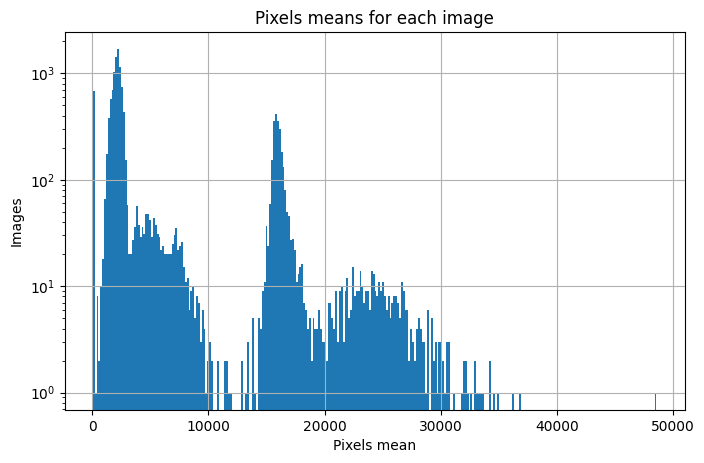

Negative patients:


<Figure size 432x288 with 0 Axes>

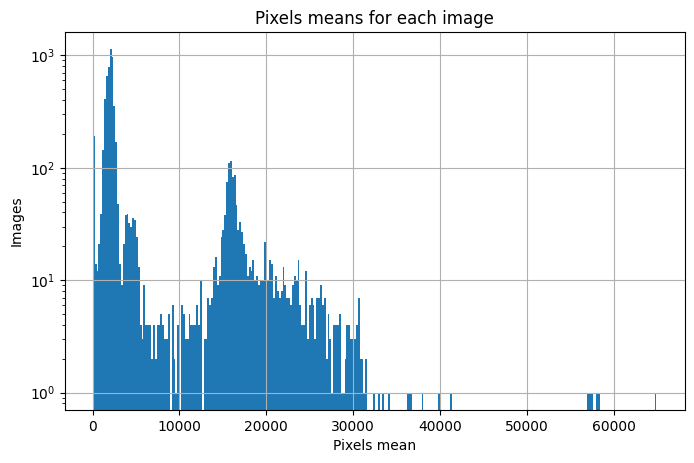

Positive + Negative patients:


<Figure size 432x288 with 0 Axes>

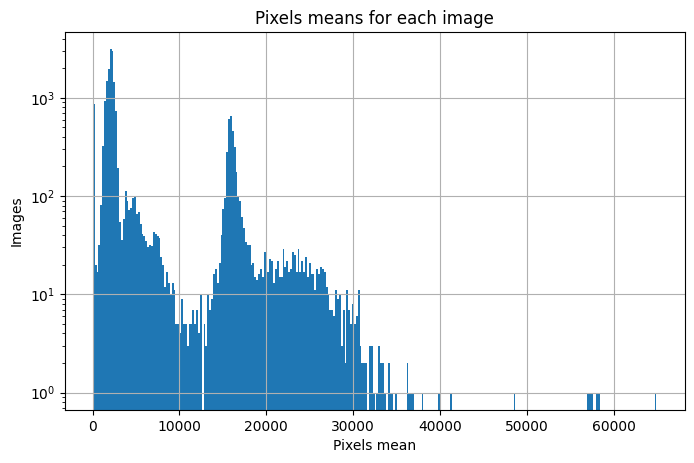

<Figure size 432x288 with 0 Axes>

In [27]:
print("Positive patients:")
create_histogram(data=posi_stats["means"],
                 title="Pixels means for each image",
                 ylabel="Images",
                 xlabel="Pixels mean",
                 bins=300,
                 fig_size=(8, 5))

print("Negative patients:")
create_histogram(data=neg_stats["means"],
                 title="Pixels means for each image",
                 ylabel="Images",
                 xlabel="Pixels mean",
                 bins=300,
                 fig_size=(8, 5))

print("Positive + Negative patients:")
create_histogram(data=posi_stats["means"] + neg_stats["means"],
                 title="Pixels means for each image",
                 ylabel="Images",
                 xlabel="Pixels mean",
                 bins=300,
                 fig_size=(8, 5))

Positive patients:


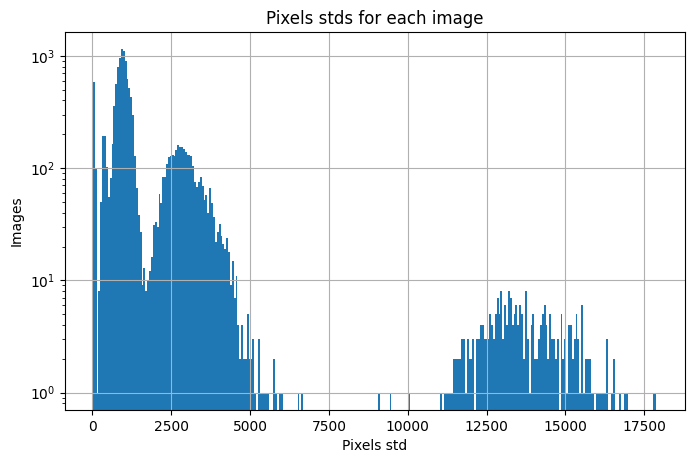

Negative patients:


<Figure size 432x288 with 0 Axes>

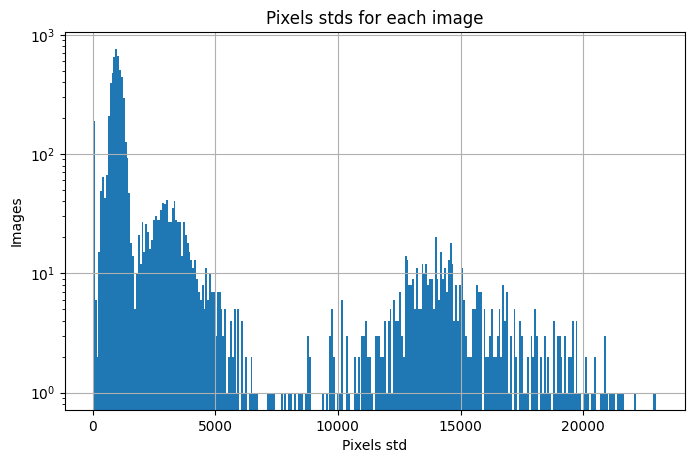

Positive + Negative patients:


<Figure size 432x288 with 0 Axes>

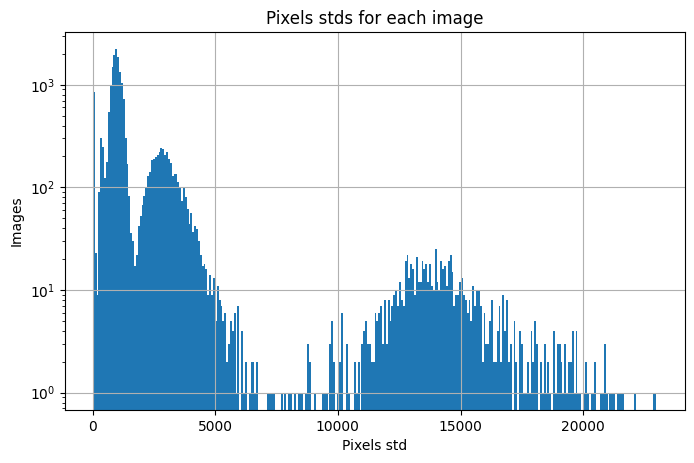

<Figure size 432x288 with 0 Axes>

In [28]:
print("Positive patients:")
create_histogram(data=posi_stats["stds"],
                 title="Pixels stds for each image",
                 ylabel="Images",
                 xlabel="Pixels std",
                 bins=300,
                 fig_size=(8, 5))

print("Negative patients:")
create_histogram(data=neg_stats["stds"],
                 title="Pixels stds for each image",
                 ylabel="Images",
                 xlabel="Pixels std",
                 bins=300,
                 fig_size=(8, 5))

print("Positive + Negative patients:")
create_histogram(data=posi_stats["stds"] + neg_stats["stds"],
                 title="Pixels stds for each image",
                 ylabel="Images",
                 xlabel="Pixels std",
                 bins=300,
                 fig_size=(8, 5))

Show a histogram with the maximum pixels values extracted from each image

Positive patients:


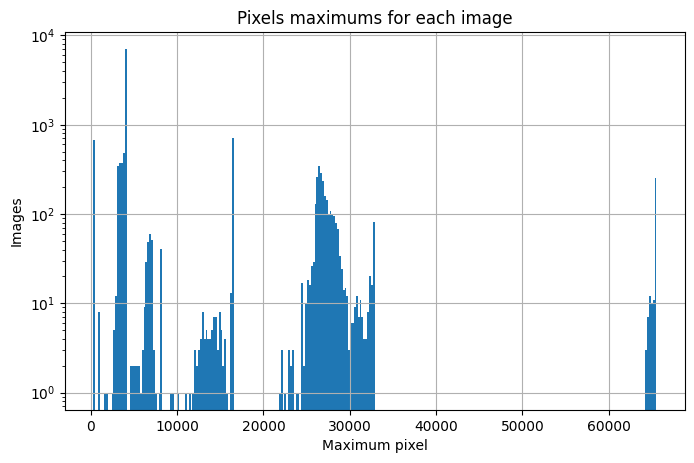

Negative patients:


<Figure size 432x288 with 0 Axes>

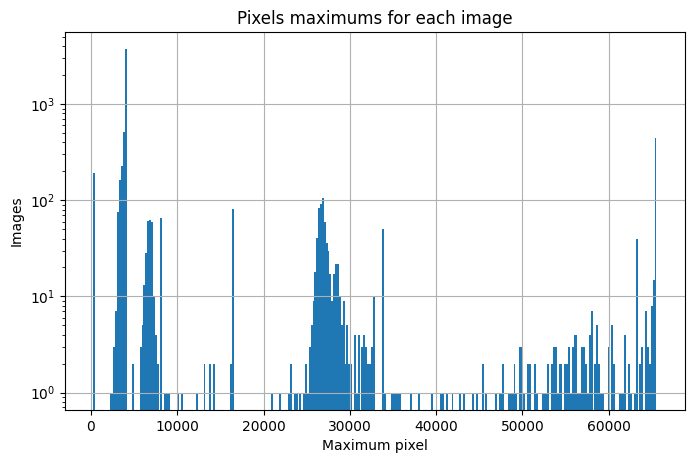

Positive + Negative patients:


<Figure size 432x288 with 0 Axes>

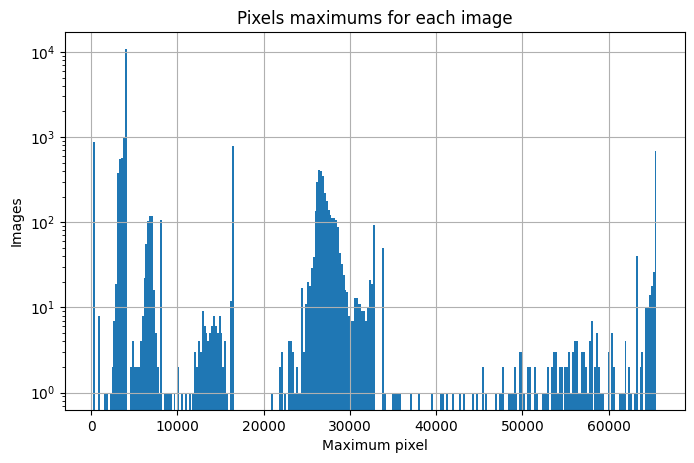

<Figure size 432x288 with 0 Axes>

In [29]:
print("Positive patients:")
create_histogram(data=posi_stats["maxs"],
                 title="Pixels maximums for each image",
                 ylabel="Images",
                 xlabel="Maximum pixel",
                 bins=300,
                 fig_size=(8, 5))

print("Negative patients:")
create_histogram(data=neg_stats["maxs"],
                 title="Pixels maximums for each image",
                 ylabel="Images",
                 xlabel="Maximum pixel",
                 bins=300,
                 fig_size=(8, 5))

print("Positive + Negative patients:")
create_histogram(data=posi_stats["maxs"] + neg_stats["maxs"],
                 title="Pixels maximums for each image",
                 ylabel="Images",
                 xlabel="Maximum pixel",
                 bins=300,
                 fig_size=(8, 5))

Show a histogram with the minimum pixels values extracted from each image

Positive patients:


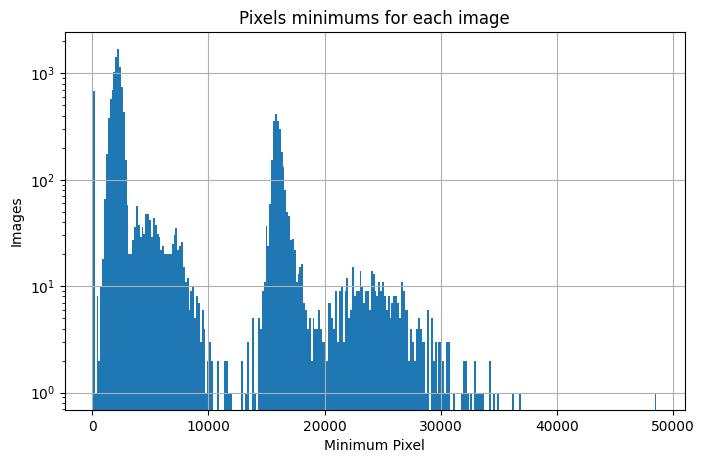

Negative patients:


<Figure size 432x288 with 0 Axes>

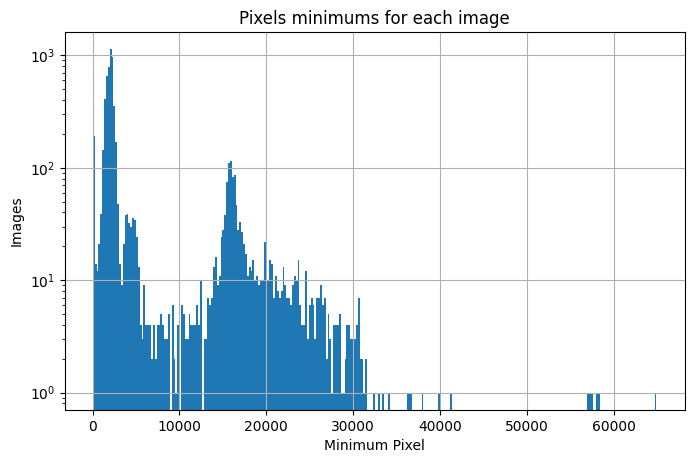

Positive + Negative patients:


<Figure size 432x288 with 0 Axes>

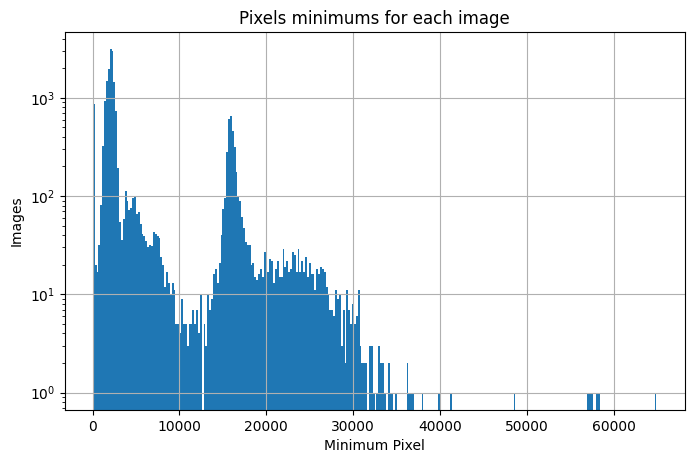

<Figure size 432x288 with 0 Axes>

In [30]:
print("Positive patients:")
create_histogram(data=posi_stats["mins"],
                 title="Pixels minimums for each image",
                 ylabel="Images",
                 xlabel="Minimum Pixel",
                 bins=300,
                 fig_size=(8, 5))

print("Negative patients:")
create_histogram(data=neg_stats["mins"],
                 title="Pixels minimums for each image",
                 ylabel="Images",
                 xlabel="Minimum Pixel",
                 bins=300,
                 fig_size=(8, 5))

print("Positive + Negative patients:")
create_histogram(data=posi_stats["mins"] + neg_stats["mins"],
                 title="Pixels minimums for each image",
                 ylabel="Images",
                 xlabel="Minimum Pixel",
                 bins=300,
                 fig_size=(8, 5))

Count different images shapes

In [31]:
print("Images shapes count in positive patients:")
posi_sorted_counts = np.array(sorted(dict(Counter(posi_stats["shapes"])).items(), key=lambda x: x[1], reverse=True), dtype=object)
for shape, count in posi_sorted_counts:
    print(f"{shape}: {count}")

Images shapes count in positive patients:
(2336, 2836): 1166
(3480, 4248): 1085
(3488, 4256): 1027
(3480, 4240): 852
(2544, 3056): 814
(2320, 2832): 630
(2800, 3408): 439
(3032, 3032): 315
(1140, 1387): 313
(2436, 3032): 281
(3052, 3052): 273
(2021, 2021): 264
(2539, 3050): 256
(2416, 2872): 255
(2540, 2880): 248
(2400, 2880): 196
(1760, 2140): 181
(2801, 2802): 159
(2991, 2992): 140
(2874, 2840): 119
(2330, 2846): 114
(2536, 3048): 114
(4020, 4891): 90
(2520, 3032): 82
(2010, 2446): 79
(4240, 3480): 74
(2801, 2798): 65
(2428, 2428): 62
(2010, 2431): 46
(2560, 3072): 44
(2012, 2012): 44
(3006, 3006): 38
(3000, 3000): 37
(2874, 2808): 35
(2801, 2992): 35
(2014, 2014): 34
(2832, 2320): 34
(3052, 3004): 34
(4248, 3480): 31
(3072, 2560): 30
(3520, 4280): 28
(3056, 2544): 28
(3198, 3056): 26
(3052, 3012): 26
(2446, 2010): 25
(3052, 3020): 23
(2320, 2828): 21
(3052, 2996): 20
(3052, 3028): 18
(3488, 3488): 17
(2874, 2816): 16
(2996, 3052): 15
(3052, 2980): 14
(2180, 2660): 13
(2548, 3060): 1

In [32]:
print("Images shapes count in negative patients:")
neg_sorted_counts = np.array(sorted(dict(Counter(neg_stats["shapes"])).items(), key=lambda x: x[1], reverse=True), dtype=object)
for shape, count in neg_sorted_counts:
    print(f"{shape}: {count}")

Images shapes count in negative patients:
(3032, 3032): 410
(2336, 2836): 371
(2539, 3050): 281
(2428, 2428): 252
(2330, 2846): 246
(1760, 2140): 200
(2021, 2021): 191
(2801, 2802): 187
(2874, 2840): 183
(2320, 2832): 165
(3480, 4248): 156
(3052, 3052): 135
(2991, 2992): 129
(2436, 3032): 124
(2544, 3056): 115
(2536, 3048): 114
(1140, 1387): 106
(3480, 4240): 103
(2540, 2880): 78
(2010, 2446): 76
(3320, 3408): 58
(2520, 3032): 52
(4020, 4891): 49
(2832, 2320): 43
(3488, 4256): 41
(2014, 2014): 39
(3000, 3000): 35
(2328, 2928): 33
(3520, 4280): 32
(2446, 2010): 31
(2801, 2992): 29
(2874, 2808): 26
(2800, 3408): 24
(3012, 3052): 19
(2548, 3060): 19
(2010, 2431): 18
(2180, 2660): 17
(2416, 2872): 17
(4240, 3480): 17
(3006, 3006): 17
(2801, 2798): 16
(3004, 3052): 14
(2996, 3052): 12
(3001, 3001): 12
(4248, 3480): 10
(3072, 2560): 10
(2874, 2800): 10
(3048, 2536): 10
(3408, 3320): 9
(2781, 2987): 9
(2048, 2500): 8
(2234, 2428): 8
(2989, 2992): 8
(2560, 3072): 7
(2846, 2330): 7
(2928, 2328)

In [33]:
print("Images shapes count in positive + negative patients:")
all_sorted_counts = np.array(sorted(dict(Counter(posi_stats["shapes"] + neg_stats["shapes"])).items(), key=lambda x: x[1], reverse=True), dtype=object)
for shape, count in all_sorted_counts:
    print(f"{shape}: {count}")

Images shapes count in positive + negative patients:
(2336, 2836): 1537
(3480, 4248): 1241
(3488, 4256): 1068
(3480, 4240): 955
(2544, 3056): 929
(2320, 2832): 795
(3032, 3032): 725
(2539, 3050): 537
(2800, 3408): 463
(2021, 2021): 455
(1140, 1387): 419
(3052, 3052): 408
(2436, 3032): 405
(1760, 2140): 381
(2330, 2846): 360
(2801, 2802): 346
(2540, 2880): 326
(2428, 2428): 314
(2874, 2840): 302
(2416, 2872): 272
(2991, 2992): 269
(2536, 3048): 228
(2400, 2880): 196
(2010, 2446): 155
(4020, 4891): 139
(2520, 3032): 134
(4240, 3480): 91
(2801, 2798): 81
(2832, 2320): 77
(2014, 2014): 73
(3000, 3000): 72
(3320, 3408): 69
(2801, 2992): 64
(2010, 2431): 64
(2874, 2808): 61
(3520, 4280): 60
(2446, 2010): 56
(3006, 3006): 55
(2560, 3072): 51
(2012, 2012): 45
(4248, 3480): 41
(2328, 2928): 41
(3072, 2560): 40
(3052, 3004): 38
(2548, 3060): 32
(3056, 2544): 32
(2180, 2660): 30
(3012, 3052): 29
(3198, 3056): 29
(3052, 3012): 28
(2996, 3052): 27
(3052, 3020): 26
(3052, 3028): 24
(3004, 3052): 24


(2618, 3005): 1
(2438, 2803): 1
(2585, 2212): 1
(2504, 2960): 1
(2818, 2057): 1
(2169, 2033): 1
(1168, 1237): 1
(2819, 2501): 1
(2392, 3014): 1
(1707, 2012): 1
(2952, 2973): 1
(2981, 2527): 1
(2984, 2992): 1
(2638, 1986): 1
(2021, 1753): 1
(2021, 1762): 1
(1738, 2008): 1
(1984, 1666): 1
(2248, 2692): 1
(2511, 2977): 1
(2760, 2528): 1
(3001, 2984): 1
(2974, 2993): 1
(2380, 2996): 1
(3001, 2514): 1
(2985, 2612): 1
(2878, 2188): 1
(2022, 1905): 1
(2355, 2476): 1
(2387, 2988): 1
(1909, 2022): 1
(2984, 2970): 1
(2984, 2968): 1
(2997, 2982): 1
(2999, 2563): 1
(2894, 2946): 1
(2534, 2190): 1
(2841, 2435): 1
(2021, 1976): 1
(2021, 1979): 1
(2874, 2868): 1
(2702, 3001): 1
(1631, 2310): 1
(2986, 2622): 1
(2978, 2911): 1
(2702, 2980): 1
(2714, 2522): 1
(2484, 2774): 1
(2329, 2989): 1
(2593, 2530): 1
(2247, 2135): 1
(2908, 3036): 1
(3005, 3005): 1
(2321, 2641): 1
(2332, 2589): 1
(1739, 2012): 1
(2973, 2691): 1
(2779, 1738): 1
(1753, 2022): 1
(2448, 2880): 1
(2660, 2452): 1
(2398, 2732): 1
(2548, 2

Scatter plot to view the general shape distributions. To create this plot we take into account the top "N" most frequent shapes.

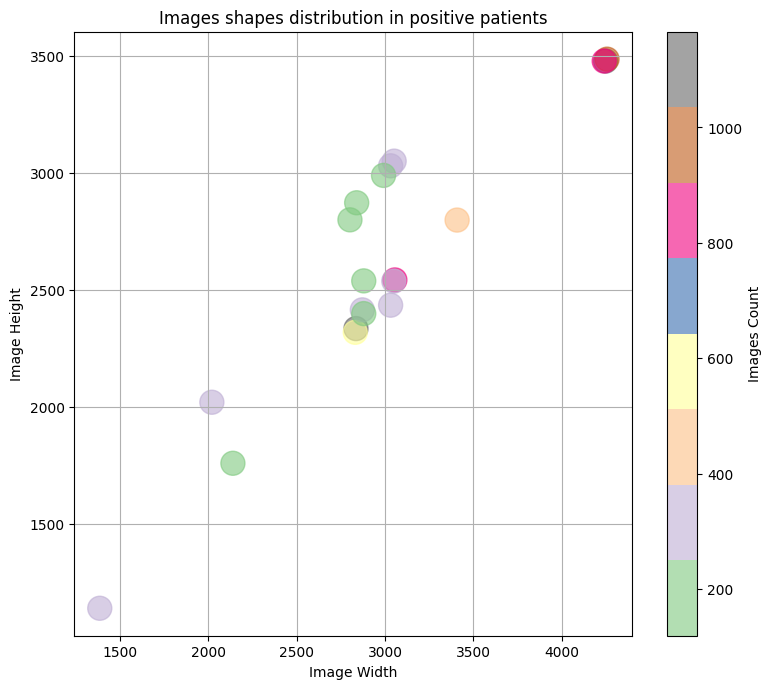

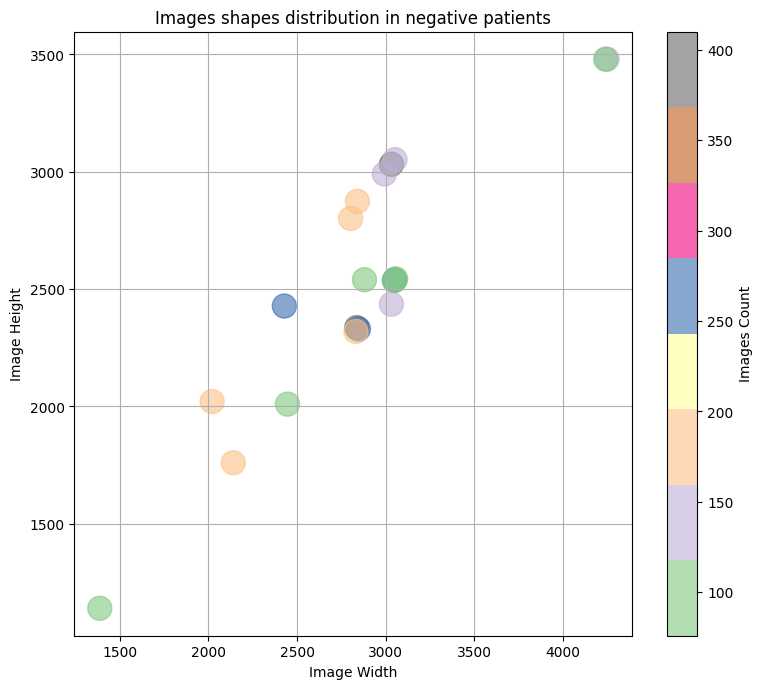

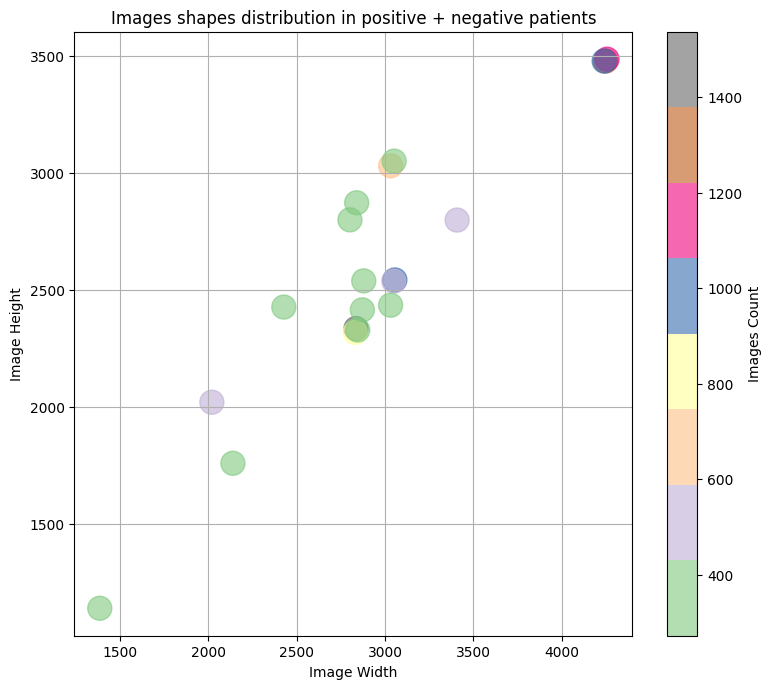

In [34]:
#
# Positive patients
#
N = 20  # Select the top 40 most frequent shapes
selected_counts = posi_sorted_counts[:N,:]

heights, widths = zip(*selected_counts[:,0]) # Split height and width values

colors = np.array(selected_counts[:,1])  # Get color form the count number
area = 300  # Size of the circles
plt.figure(figsize=(9,8), dpi=100)
plt.scatter(widths, heights, s=area, c=colors, cmap="Accent", alpha=0.6)
plt.grid()
cbar = plt.colorbar()
cbar.ax.set_ylabel("Images Count")
plt.title("Images shapes distribution in positive patients")
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

#
# Negative patients
#
N = 20  # Select the top 40 most frequent shapes
selected_counts = neg_sorted_counts[:N,:]

heights, widths = zip(*selected_counts[:,0]) # Split height and width values

colors = np.array(selected_counts[:,1])  # Get color form the count number
area = 300  # Size of the circles
plt.figure(figsize=(9,8), dpi=100)
plt.scatter(widths, heights, s=area, c=colors, cmap="Accent", alpha=0.6)
plt.grid()
cbar = plt.colorbar()
cbar.ax.set_ylabel("Images Count")
plt.title("Images shapes distribution in negative patients")
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

#
# Positive + Negative patients
#
N = 20  # Select the top 40 most frequent shapes
selected_counts = all_sorted_counts[:N,:]

heights, widths = zip(*selected_counts[:,0]) # Split height and width values

colors = np.array(selected_counts[:,1])  # Get color form the count number
area = 300  # Size of the circles
plt.figure(figsize=(9,8), dpi=100)
plt.scatter(widths, heights, s=area, c=colors, cmap="Accent", alpha=0.6)
plt.grid()
cbar = plt.colorbar()
cbar.ax.set_ylabel("Images Count")
plt.title("Images shapes distribution in positive + negative patients")
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

## Labels Analysis

### Load TSVs with labels by session

#### 1. Positive patients

In [35]:
posi_labels_df = pd.read_csv(posi_labels_path, sep="\t")
posi_labels_df.head()

,Unnamed: 0,PatientID,ReportID,Report,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,0,sub-S03080,ses-E07791,se compara con rx previa . estabilidad radio...,"['unchanged', 'infiltrates']","['loc lower lung field', 'loc peripheral', 'lo...","['unchanged', 'infiltrates', 'loc peripheral',...",[C0277877],"[C0205100,C0929434,C0444532,C0443246]"
1,1,sub-S03080,ses-E06235,juicio clinico valorar evolucion radiologica n...,"['COVID 19', ' consolidation', ' pneumonia']","['loc middle lung field', 'loc right']","['COVID 19', ' consolidation', ' pneumonia', '...","[C5203670,C0521530,C0032285]","[C0929434,C0444532]"
2,2,sub-S03080,ses-E06174,se compara con estudios previos . poco inspir...,"['unchanged', 'increased density']","['loc lung field', 'loc peripheral', 'loc left...","['unchanged', 'exclude', 'increased density', ...",[C1443940],"[C0225759,C0205100,C0443246,C0929434,C0444532]"
3,3,sub-S03080,ses-E07930,se raliza se compara con estudio previo del 06...,['infiltrates'],"['loc middle lung field', 'loc lung field', 'l...","['infiltrates', 'loc middle lung field', 'loc ...",[C0277877],"[C0929434,C0225759,C0205100]"
4,4,sub-S03080,ses-E06408,poco inspirada . no se observan imagenes suge...,['normal'],"['loc cardiac', 'loc costophrenic angle', 'loc...","['exclude', 'normal', 'loc cardiac', 'loc cost...",[C0205307],"[C1522601,C0230151,C0504099,C0504100]"


#### 2. Negative patients

In [36]:
neg_labels_df = pd.read_csv(neg_labels_path, sep="\t")
neg_labels_df.head()

,Unnamed: 0,PatientID,ReportID,Report,Labels,Localizations,LabelsLocalizationsBySentence,labelCUIS,LocalizationsCUIS
0,0,sub-S05273,ses-E09897,estudio impresion diagnostica no hay masas ...,['surgery neck'],"['loc cardiac', 'loc cervical vertebrae']","['normal', 'normal', 'loc cardiac', 'surgery n...",[C0185773],"[C1522601,C3665420]"
1,1,sub-S05273,ses-E09891,estudio impresion diagnostica no hay masas ...,['surgery neck'],"['loc cardiac', 'loc cervical vertebrae']","['normal', 'normal', 'loc cardiac', 'surgery n...",[C0185773],"[C1522601,C3665420]"
2,2,sub-S05863,ses-E10693,se compara con rx previa . se evidencia un au...,"['unchanged', 'ground glass pattern', ' pneumo...","['loc middle lobe', 'loc lingula']","['unchanged', 'ground glass pattern', ' pneumo...","[C3544344,C0032285]","[C4281590,C0225740]"
3,3,sub-S06871,ses-E12201,patron intersticial bibasal de distribucion ce...,"['bronchiectasis', ' interstitial pattern', ''...","['loc bronchi', 'loc right', 'loc pleural', 'l...","['bronchiectasis', ' interstitial pattern', 'l...","[C0006267,C2073538,,C5203671]","[C0006255,C0444532,C0032225,C0205099]"
4,4,sub-S08042,ses-E14289,mediastino de grosor conservado no apreciando...,"['COVID 19 uncertain', ' increased density']","['loc right', 'loc cardiac', 'loc basal', 'loc...","['normal', 'loc mediastinum', 'normal', 'loc c...","[C5203671,C1443940]","[C0444532,C1522601,C1282378,C0025066,C0262950,..."


### Look for nan values

#### 1. Positive patients

In [37]:
print("NaNs count by column:")
print(posi_labels_df.isna().sum())

NaNs count by column:
Unnamed: 0                          0
PatientID                           0
ReportID                            0
Report                           1233
Labels                             20
Localizations                      22
LabelsLocalizationsBySentence      24
labelCUIS                          22
LocalizationsCUIS                  23
dtype: int64


#### 2. Negative patients

In [38]:
print("NaNs count by column:")
print(neg_labels_df.isna().sum())

NaNs count by column:
Unnamed: 0                         0
PatientID                          0
ReportID                           0
Report                           284
Labels                             6
Localizations                      6
LabelsLocalizationsBySentence      6
labelCUIS                          0
LocalizationsCUIS                  0
dtype: int64


### Check subjects and sessions IDs

#### 1. Positive patients

In [39]:
n_posi_subjects = posi_labels_df['PatientID'].nunique()
n_posi_sessions = posi_labels_df['ReportID'].nunique()
print(f"Number of subjects: {n_posi_subjects}")
print(f"Number of sessions: {n_posi_sessions}")

# Compare the sets of unique sessions IDs of each DataFrame
imgs_df_sess = set(posi_df['session'])
labels_df_sess = set(posi_labels_df["ReportID"])
sess_diff1 = len(imgs_df_sess.difference(labels_df_sess))
sess_diff2 = len(labels_df_sess.difference(imgs_df_sess))
print(f"Number of images without labels: {sess_diff1}")
print(f"Number of labels without image: {sess_diff2}")

Number of subjects: 4898
Number of sessions: 13635
Number of images without labels: 0
Number of labels without image: 267


#### 2. Negative patients

In [40]:
n_neg_subjects = neg_labels_df['PatientID'].nunique()
n_neg_sessions = neg_labels_df['ReportID'].nunique()
print(f"Number of subjects: {n_neg_subjects}")
print(f"Number of sessions: {n_neg_sessions}")

# Compare the sets of unique sessions IDs of each DataFrame
imgs_df_sess = set(neg_df['session'])
labels_df_sess = set(neg_labels_df["ReportID"])
sess_diff1 = len(imgs_df_sess.difference(labels_df_sess))
sess_diff2 = len(labels_df_sess.difference(imgs_df_sess))
print(f"Number of images without labels: {sess_diff1}")
print(f"Number of labels without image: {sess_diff2}")

Number of subjects: 5242
Number of sessions: 7622
Number of images without labels: 0
Number of labels without image: 57


### Count labels

Note: The labels in the column "Labels" are strings representing a python list
      with the actual strings of the labels

In [41]:
# Replace the nans by the label NONE
posi_labels_df["Labels"] = posi_labels_df["Labels"].fillna('["NONE"]')
neg_labels_df["Labels"] = neg_labels_df["Labels"].fillna('["NONE"]')

posi_labels_counter = Counter()
for labels_str in posi_labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str
    posi_labels_counter.update(labels_list)  # Update the counter for each label in the list

neg_labels_counter = Counter()
for labels_str in neg_labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str
    neg_labels_counter.update(labels_list)  # Update the counter for each label in the list
    
all_labels_counter = posi_labels_counter + neg_labels_counter

Failed to process labels: "['aortic elongation', ' cardiomegaly', 'tracheostomy tube', 'central venous ca"
Failed to process labels: "['atelectasis', 'volume loss', 'hiatal hernia', 'adenopathy', ' calcified adenopathy', 'pleural effusion', 'bronchiectasis', ' cavitation', ' lobar atelectasis', 'nodule', 'hyperinflated lung', '', 'ground glass pattern', ' pneumonia', 'emp"


Show counts results

#### 1. Positive patients

In [42]:
print(f"Number of unique labels in positive patients set: {len(posi_labels_counter)}")

print("\nLabels count (sorted):")
for label, counter in sorted(posi_labels_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')

Number of unique labels in positive patients set: 180

Labels count (sorted):
"COVID 19": 2356
"increased density": 2215
"pneumonia": 2181
"normal": 1884
"unchanged": 1816
"exclude": 1702
"alveolar pattern": 1558
"interstitial pattern": 1549
"consolidation": 1402
"infiltrates": 1392
"": 1249
"ground glass pattern": 1002
"pleural effusion": 988
"cardiomegaly": 894
"suboptimal study": 574
"central venous catheter": 443
"aortic elongation": 419
"laminar atelectasis": 400
"aortic atheromatosis": 384
"costophrenic angle blunting": 361
"COVID 19 uncertain": 313
"NSG tube": 276
"endotracheal tube": 271
"nodule": 263
"viral pneumonia": 254
"vertebral degenerative changes": 224
"fibrotic band": 194
"atypical pneumonia": 193
"atelectasis": 186
"bronchovascular markings": 174
"emphysema": 160
"adenopathy": 155
"calcified densities": 153
"volume loss": 151
"central venous catheter via jugular vein": 146
"bronchiectasis": 136
"tracheostomy tube": 128
"hiatal hernia": 127
"pacemaker": 125
"reticular

#### 2. Negative patients

In [43]:
print(f"Number of unique labels in negative patients set: {len(neg_labels_counter)}")

print("\nLabels count (sorted):")
for label, counter in sorted(neg_labels_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')

Number of unique labels in negative patients set: 187

Labels count (sorted):
"normal": 1528
"": 1491
"pleural effusion": 1401
"pneumonia": 1033
"cardiomegaly": 1009
"unchanged": 859
"increased density": 781
"consolidation": 698
"interstitial pattern": 628
"nodule": 586
"COVID 19": 464
"laminar atelectasis": 461
"infiltrates": 456
"ground glass pattern": 452
"adenopathy": 441
"costophrenic angle blunting": 418
"exclude": 393
"vertebral degenerative changes": 373
"pulmonary mass": 367
"aortic elongation": 353
"emphysema": 332
"atelectasis": 331
"aortic atheromatosis": 312
"suboptimal study": 302
"alveolar pattern": 299
"calcified densities": 281
"bronchiectasis": 224
"lobar atelectasis": 218
"heart insufficiency": 218
"bronchovascular markings": 216
"COVID 19 uncertain": 200
"hiatal hernia": 188
"fibrotic band": 183
"central venous catheter": 183
"calcified adenopathy": 154
"volume loss": 152
"surgery": 143
"calcified granuloma": 138
"sternotomy": 136
"pulmonary artery enlargement": 135

#### 3. Positive + Negative Patients

In [44]:
print(f"Number of unique labels in positive + negative patients set: {len(all_labels_counter)}")

print("\nLabels count (sorted):")
for label, counter in sorted(all_labels_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')

Number of unique labels in positive + negative patients set: 190

Labels count (sorted):
"normal": 3412
"pneumonia": 3214
"increased density": 2996
"COVID 19": 2820
"": 2740
"unchanged": 2675
"pleural effusion": 2389
"interstitial pattern": 2177
"consolidation": 2100
"exclude": 2095
"cardiomegaly": 1903
"alveolar pattern": 1857
"infiltrates": 1848
"ground glass pattern": 1454
"suboptimal study": 876
"laminar atelectasis": 861
"nodule": 849
"costophrenic angle blunting": 779
"aortic elongation": 772
"aortic atheromatosis": 696
"central venous catheter": 626
"vertebral degenerative changes": 597
"adenopathy": 596
"atelectasis": 517
"COVID 19 uncertain": 513
"emphysema": 492
"pulmonary mass": 473
"calcified densities": 434
"NSG tube": 395
"bronchovascular markings": 390
"fibrotic band": 377
"bronchiectasis": 360
"endotracheal tube": 349
"viral pneumonia": 325
"heart insufficiency": 321
"lobar atelectasis": 315
"hiatal hernia": 315
"volume loss": 303
"atypical pneumonia": 258
"pacemaker": 

### Count sets of labels

#### 1. Positive patients

In [45]:
# List the sets of labels to look for
labels_sets = [["COVID 19", "pneumonia"], ["COVID 19", "infiltrates"], ["pneumonia", "infiltrates"],
               ["COVID 19"], ["pneumonia"], ["infiltrates"], ["normal"]]
labels_sets_counter = Counter()  # To store the aparitions of each labels set

for labels_str in posi_labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str

    # Check if any labels set is a subset of the labels_list
    for l_set in labels_sets:
        if set(l_set).issubset(labels_list):
            labels_sets_counter.update([" + ".join(l_set)])  # Update the counter of the labels set

Failed to process labels: "['aortic elongation', ' cardiomegaly', 'tracheostomy tube', 'central venous ca"
Failed to process labels: "['atelectasis', 'volume loss', 'hiatal hernia', 'adenopathy', ' calcified adenopathy', 'pleural effusion', 'bronchiectasis', ' cavitation', ' lobar atelectasis', 'nodule', 'hyperinflated lung', '', 'ground glass pattern', ' pneumonia', 'emp"


In [46]:
print("\nLabels sets count (sorted):")
for label, counter in sorted(labels_sets_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')


Labels sets count (sorted):
"COVID 19": 2356
"pneumonia": 2119
"normal": 1884
"infiltrates": 1374
"COVID 19 + pneumonia": 1327
"pneumonia + infiltrates": 281
"COVID 19 + infiltrates": 277


#### 2. Negative patients

In [47]:
# List the sets of labels to look for
labels_sets = [["COVID 19", "pneumonia"], ["COVID 19", "infiltrates"], ["pneumonia", "infiltrates"],
               ["COVID 19"], ["pneumonia"], ["infiltrates"], ["normal"]]
labels_sets_counter = Counter()  # To store the aparitions of each labels set

for labels_str in neg_labels_df["Labels"]:
    labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str

    # Check if any labels set is a subset of the labels_list
    for l_set in labels_sets:
        if set(l_set).issubset(labels_list):
            labels_sets_counter.update([" + ".join(l_set)])  # Update the counter of the labels set

In [48]:
print("\nLabels sets count (sorted):")
for label, counter in sorted(labels_sets_counter.items(), key=lambda x: x[1], reverse=True):
    print(f'"{label}": {counter}')


Labels sets count (sorted):
"normal": 1528
"pneumonia": 999
"COVID 19": 464
"infiltrates": 446
"COVID 19 + pneumonia": 202
"pneumonia + infiltrates": 134
"COVID 19 + infiltrates": 29


## Analyze COVID tests labels (ONLY for posi patients)

### Load TSV with COVID tests results

In [49]:
tests_df = pd.read_csv(covid_tests_path, sep="\t")
tests_df.head()

,label,subject,date,test,result,participant,Unnamed: 6
0,1,1,20.03.2020,PCR,POSITIVO,sub-S03044,NaN
1,1,1,18.03.2020,PCR,POSITIVO,sub-S03044,NaN
2,2,2,19.04.2020,PCR,NEGATIVO,sub-S03046,NaN
3,2,2,18.03.2020,PCR,POSITIVO,sub-S03046,NaN
4,3,3,16.03.2020,PCR,POSITIVO,sub-S03045,NaN


Look for nan values

In [50]:
print("NaNs count by column:")
print(tests_df.isna().sum())

NaNs count by column:
label              0
subject            0
date               0
test               0
result             0
participant        0
Unnamed: 6     26733
dtype: int64


### Count tests types

In [51]:
print("Test types count:")
test_types_counts = tests_df["test"].value_counts()
print(test_types_counts)

Test types count:
PCR    16442
IGG     4273
ACT     3294
IGM     2724
Name: test, dtype: int64


### Count tests results

In [52]:
print("Test results count:")
test_res_counts = tests_df["result"].value_counts()
print(test_res_counts)

Test results count:
POSITIVO         14253
NEGATIVO         11393
INDETERMINADO     1087
Name: result, dtype: int64


## Use COVID tests to improve data labeling

For each subject we compare the labels of each session with the results available from the COVID tests labels.
If we detect that some session hasn't the 'COVID 19' label but the subject has a POSITIVE COVID test with approximately the same date, we add the 'COVID 19' label to the session.

### Prepare data

In [53]:
# Get only the positive tests
positive_tests = tests_df[tests_df["result"] == "POSITIVO"].copy()

# Convert dates from strings to datetime objects
positive_tests["date"] = pd.to_datetime(positive_tests["date"], format="%d.%m.%Y")

# Group tests by subject ID
#  - Note: A subject can have several tests
positive_tests_by_sub = positive_tests.groupby(["participant"])

# Group the sessions labels by subject ID
labels_by_sub = posi_labels_df.groupby(["PatientID"])

### Configure parameters

In [54]:
'''
Set the range of days before and after a COVID test to
take the test result as valid to label a session
'''
valid_prev_days = 0  # Number of days before the COVID test
valid_post_days = 0  # Number of days after the COVID test

verbose = 1  # 0: only errors, >0: Full logs

### Process tests data

In [55]:
fixed_labels = 0  # To count the sessions labels modified adding 'COVID 19'

# Avoid to change labels of sessions with one of these labels
#labels_to_avoid = []
labels_to_avoid = ["exclude", "normal"]
# Only try to change the labels os sessions with at least one of these labels
#mandatory_labels = []
mandatory_labels = ["COVID 19 uncertain", "infiltrates", "pneumonia"]

# Iterate over the groups of tests of each subject
#  - IMPORTANT: "positive_tests_by_sub" only contains positive tests
for sub_id, sub_tests in positive_tests_by_sub:
    # Load subject sessions data
    sub_sessions_tsv = os.path.join(posi_path, sub_id, f"{sub_id}_sessions.tsv")
    # Check if the data exists
    if not os.path.isfile(sub_sessions_tsv):
        print("---------------------------------------------------")
        if not os.path.isdir(os.path.dirname(sub_sessions_tsv)):
            print(f'| Error: Missing subject directory of "{sub_id}"')
        else:
            print(f'| Error: Missing file "{sub_sessions_tsv}"')
        print("---------------------------------------------------")
        continue  # skip the subject     
    sub_sessions_df = pd.read_csv(sub_sessions_tsv, sep="\t")
    
    # Convert sessions dates from strings to datetime objects
    sub_sessions_df["study_date"] = pd.to_datetime(sub_sessions_df["study_date"], format="%Y%m%d")
    
    # Get the list of labels for each session of the subject
    sub_sessions_labels = labels_by_sub.get_group(sub_id)[['ReportID','Labels']]
    
    # Compare the labels of each session with the COVID tests
    for idx, sess_row in sub_sessions_df.iterrows():
        sess_id = sess_row["session_id"]
        sess_date = sess_row["study_date"]
        
        # Get the list of labels of the current session
        sess_labels_row = sub_sessions_labels[sub_sessions_labels["ReportID"] == sess_id]
        labels_str = sess_labels_row["Labels"].values[0]
        labels_list = get_labels_from_str(labels_str, verbose=True)  # Get a list object from the str
        
        # Skip sessions with the COVID label (Nothing to change here)
        if 'COVID 19' in labels_list:
            continue
        # Skip sessions with at least one of the labels to avoid
        if any(l in labels_to_avoid for l in labels_list):
            continue
        # Skip sessions without at least one mandatory label
        if len(mandatory_labels) and not any(l in mandatory_labels for l in labels_list):
            continue
            
        # Look if any of the tests can affect the session labels (by time difference)
        for test_date in sub_tests["date"]:
            # Compute time difference in days
            days_diff = (sess_date - test_date).days

            # Check if is a valid difference to fix the label
            if -valid_prev_days <= days_diff <= valid_post_days:
                if verbose:
                    print(f"FIX: Sess ID: {sess_id} Days diff: {days_diff} - session labels: {labels_list}")
                fixed_labels += 1               
                break  # Don't look for more tests

FIX: Sess ID: ses-E06790 Days diff: 0 - session labels: ['chronic changes', 'increased density', 'pneumonia']
FIX: Sess ID: ses-E06910 Days diff: 0 - session labels: ['atypical pneumonia', 'consolidation', 'pneumonia']
FIX: Sess ID: ses-E20387 Days diff: 0 - session labels: ['atelectasis', 'infiltrates', 'ground glass pattern', 'bronchiectasis', 'pleural effusion', 'tracheostomy tube', 'pneumonia', 'pulmonary edema', 'pulmonary fibrosis']
FIX: Sess ID: ses-E07054 Days diff: 0 - session labels: ['unchanged', 'infiltrates']
FIX: Sess ID: ses-E06578 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E07055 Days diff: 0 - session labels: ['hilar congestion', 'pleural effusion', 'pulmonary edema', 'COVID 19 uncertain']
FIX: Sess ID: ses-E06960 Days diff: 0 - session labels: ['cardiomegaly', 'mediastinal enlargement', 'COVID 19 uncertain', 'infiltrates']
FIX: Sess ID: ses-E06883 Days diff: 0 - session labels: ['pneumonia', 'viral pneumonia']
FIX: Sess ID: ses-E06980 Days diff: 

FIX: Sess ID: ses-E07069 Days diff: 0 - session labels: ['ground glass pattern', 'infiltrates', 'fibrotic band']
FIX: Sess ID: ses-E07158 Days diff: 0 - session labels: ['hemidiaphragm elevation', 'volume loss', 'COVID 19 uncertain', 'reticulonodular interstitial pattern', 'ground glass pattern', 'interstitial pattern']
FIX: Sess ID: ses-E07251 Days diff: 0 - session labels: ['infiltrates', 'pneumonia']
FIX: Sess ID: ses-E07252 Days diff: 0 - session labels: ['infiltrates', 'pneumonia', 'viral pneumonia']
FIX: Sess ID: ses-E07287 Days diff: 0 - session labels: ['atelectasis', 'hemidiaphragm elevation', 'pneumonia']
FIX: Sess ID: ses-E07398 Days diff: 0 - session labels: ['air bronchogram', 'alveolar pattern', 'consolidation', 'consolidation', 'alveolar pattern', 'pneumonia']
FIX: Sess ID: ses-E07403 Days diff: 0 - session labels: ['increased density', 'pneumonia', 'unchanged']
FIX: Sess ID: ses-E07996 Days diff: 0 - session labels: ['infiltrates', 'pleural effusion', 'unchanged']
FIX: 

FIX: Sess ID: ses-E08491 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E08762 Days diff: 0 - session labels: ['infiltrates', 'pneumonia']
FIX: Sess ID: ses-E08506 Days diff: 0 - session labels: ['pneumonia', 'increased density']
FIX: Sess ID: ses-E08517 Days diff: 0 - session labels: ['heart insufficiency', 'infiltrates', 'pulmonary edema', 'cardiomegaly', 'hilar enlargement', 'pleural effusion', '']
FIX: Sess ID: ses-E08519 Days diff: 0 - session labels: ['COVID 19 uncertain', 'infiltrates', 'pneumonia']
FIX: Sess ID: ses-E08523 Days diff: 0 - session labels: ['alveolar pattern', 'pneumonia']
FIX: Sess ID: ses-E08529 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E08533 Days diff: 0 - session labels: ['ground glass pattern', 'infiltrates', 'COVID 19 uncertain', 'pneumonia']
FIX: Sess ID: ses-E08548 Days diff: 0 - session labels: ['infiltrates', 'pneumonia', 'viral pneumonia', 'endoprosthesis', 'vertebral degenerative changes']
FIX: Sess ID: ses-E08

| Error: Missing subject directory of "sub-S08546"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08547"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08548"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08549"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08550"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08551"
---------------------------------------------------
---------------------------------------------------
| Error: Missing subject directory of "sub-S08552"
-------------------

FIX: Sess ID: ses-E22065 Days diff: 0 - session labels: ['pneumonia', '', 'unchanged']
FIX: Sess ID: ses-E23855 Days diff: 0 - session labels: ['suboptimal study', 'infiltrates', 'cardiomegaly']
FIX: Sess ID: ses-E16548 Days diff: 0 - session labels: ['COVID 19 uncertain', 'pleural effusion']
FIX: Sess ID: ses-E24444 Days diff: 0 - session labels: ['interstitial pattern', 'pleural effusion', 'COVID 19 uncertain']
FIX: Sess ID: ses-E18705 Days diff: 0 - session labels: ['cardiomegaly', 'pacemaker', 'aortic atheromatosis', 'aortic elongation', 'atelectasis', 'infiltrates']
FIX: Sess ID: ses-E18602 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E16495 Days diff: 0 - session labels: ['infiltrates', 'pleural effusion']
FIX: Sess ID: ses-E20827 Days diff: 0 - session labels: ['increased density', 'pneumonia', 'cardiomegaly', 'vascular hilar enlargement']
FIX: Sess ID: ses-E18638 Days diff: 0 - session labels: ['infiltrates', 'pneumonia', 'viral pneumonia']
FIX: Sess ID: ses

FIX: Sess ID: ses-E18772 Days diff: 0 - session labels: ['pneumonia']
FIX: Sess ID: ses-E17068 Days diff: 0 - session labels: ['increased density', 'COVID 19 uncertain', 'pneumonia', 'hemidiaphragm elevation']
FIX: Sess ID: ses-E25326 Days diff: 0 - session labels: ['atelectasis', 'infiltrates', 'aortic elongation']
FIX: Sess ID: ses-E25194 Days diff: 0 - session labels: ['aortic elongation', 'infiltrates', 'pneumonia']
FIX: Sess ID: ses-E25182 Days diff: 0 - session labels: ['pneumonia', 'increased density']
FIX: Sess ID: ses-E24096 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E21163 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E17535 Days diff: 0 - session labels: ['COVID 19 uncertain', 'alveolar pattern', 'interstitial pattern', 'cardiomegaly']
FIX: Sess ID: ses-E24166 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E20100 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E24991 Days diff: 0 - session labels: ['

FIX: Sess ID: ses-E23093 Days diff: 0 - session labels: ['fibrotic band', 'COVID 19 uncertain', '', 'infiltrates']
FIX: Sess ID: ses-E26283 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E18605 Days diff: 0 - session labels: ['', 'infiltrates']
FIX: Sess ID: ses-E23140 Days diff: 0 - session labels: ['cardiomegaly', 'heart insufficiency', 'interstitial pattern', 'pleural effusion', 'COVID 19 uncertain', 'aortic atheromatosis']
FIX: Sess ID: ses-E18755 Days diff: 0 - session labels: ['pulmonary artery enlargement', 'alveolar pattern', 'infiltrates', 'mediastinal enlargement', '']
FIX: Sess ID: ses-E25459 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E19735 Days diff: 0 - session labels: ['alveolar pattern', 'consolidation', 'consolidation', 'COVID 19 uncertain']
FIX: Sess ID: ses-E19296 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E21438 Days diff: 0 - session labels: ['fibrotic band', 'infiltrates']
FIX: Sess ID: ses-E19076 Days 

FIX: Sess ID: ses-E23866 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E20468 Days diff: 0 - session labels: ['pneumonia']
FIX: Sess ID: ses-E24208 Days diff: 0 - session labels: ['alveolar pattern', 'pneumonia']
FIX: Sess ID: ses-E20538 Days diff: 0 - session labels: ['increased density', 'pneumonia', 'COVID 19 uncertain']
FIX: Sess ID: ses-E23978 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E24012 Days diff: 0 - session labels: ['increased density', 'COVID 19 uncertain']
FIX: Sess ID: ses-E23767 Days diff: 0 - session labels: ['consolidation', 'pneumonia']
FIX: Sess ID: ses-E20702 Days diff: 0 - session labels: ['COVID 19 uncertain', 'increased density', 'pneumonia']
FIX: Sess ID: ses-E26420 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E20751 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E25715 Days diff: 0 - session labels: ['alveolar pattern', 'pneumonia', 'COVID 19 uncertain']
FIX: Sess ID: ses-E24499 Da

FIX: Sess ID: ses-E24804 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E25507 Days diff: 0 - session labels: ['suboptimal study', 'infiltrates']
FIX: Sess ID: ses-E24993 Days diff: 0 - session labels: ['increased density', 'COVID 19 uncertain', 'pneumonia']
FIX: Sess ID: ses-E25296 Days diff: 0 - session labels: ['alveolar pattern', '', 'COVID 19 uncertain', 'pneumonia']
FIX: Sess ID: ses-E25118 Days diff: 0 - session labels: ['increased density', 'pneumonia']
FIX: Sess ID: ses-E25141 Days diff: 0 - session labels: ['pneumonia', 'increased density', 'atelectasis', 'cardiomegaly']
FIX: Sess ID: ses-E25238 Days diff: 0 - session labels: ['infiltrates']
FIX: Sess ID: ses-E25336 Days diff: 0 - session labels: ['alveolar pattern', 'COVID 19 uncertain', 'pneumonia']
FIX: Sess ID: ses-E25363 Days diff: 0 - session labels: ['interstitial pattern', 'increased density', 'pneumonia']
FIX: Sess ID: ses-E25430 Days diff: 0 - session labels: ['alveolar pattern', 'interstitial patt

In [56]:
print(f"Sessions labels modified adding 'COVID 19': {fixed_labels}")

Sessions labels modified adding 'COVID 19': 532
